# Load file

In [ ]:
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

In [2]:
df_path = "C:/Users/Enduser/OneDrive - Asia Pacific University/uni/Y3S2/fyp/Model_trial/btc_trial_dataset2.csv"
dataset_df = pd.read_csv(df_path)

# Feature Selection: Dropping Irrelevant or Redundant Columns


In [3]:
drop_cols = ['tx_hash', 'is_malicious', 'all_malicious', 'mean_in_btc', 'mean_out_btc']
dataset_df.drop(columns=drop_cols, inplace=True)

In [4]:
dataset_df.head()

,indegree,outdegree,in_btc,out_btc,total_btc,in_malicious,out_malicious,out_and_tx_malicious
0,4,2,0.478187,0.476987,0.955174,0,0,0
1,3,2,2.019000,2.018500,4.037500,0,0,0
2,1,1,0.180100,0.180100,0.360200,0,0,0
3,1,2,5.879800,5.879300,11.759100,0,0,0
4,4,2,0.495906,0.495406,0.991312,0,0,0


# Data Splitting

In [5]:
from sklearn.model_selection import train_test_split

# Load dataset
X = dataset_df.drop('out_and_tx_malicious', axis=1)
y = dataset_df['out_and_tx_malicious']

# Split dataset into Train (80%) and Test (20%) ensuring stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Further split Train into Train (90%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
)

print("Data Split Complete:")
print(f"Train Size: {X_train.shape[0]}")
print(f"Validation Size: {X_val.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")


Data Split Complete:
Train Size: 72000
Validation Size: 8000
Test Size: 20000


In [6]:
print(X_test.columns)

Index(['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc',
       'in_malicious', 'out_malicious'],
      dtype='object')


# Feature Scaling: Logarithmic Transformation 

In [7]:

# Define features for log transformation
log_features = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc']

# Apply log transformation
for df in [X_train, X_val, X_test]:  
    df[log_features] = np.log1p(df[log_features])  # log1p avoids log(0)

print("Log Transformation Complete")


Log Transformation Complete


# Feature Engineer

In [8]:
# Feature Engineering Function
def add_features(df):
    df['out_malicious_to_total_btc'] = df['out_malicious'] / (df['total_btc'] + 1e-6)
    df['log_total_btc'] = np.log1p(df['total_btc'])
    df['out_malicious_in_btc_interaction'] = df['out_malicious'] * df['in_btc']
    df['net_btc_flow'] = df['in_btc'] - df['out_btc']
    return df

# Apply feature engineering to Train, Validation, and Test sets
X_train_fe = add_features(X_train)
X_val_fe = add_features(X_val)
X_test_fe = add_features(X_test)

# Select the final set of features
selected_features = [
    'in_btc', 'out_btc', 'total_btc', 'out_malicious','indegree','outdegree',
    'out_malicious_to_total_btc', 'log_total_btc',
    'out_malicious_in_btc_interaction', 'net_btc_flow'
]

X_train_final = X_train_fe[selected_features]
X_val_final = X_val_fe[selected_features]
X_test_final = X_test_fe[selected_features]

print("Feature Engineering Complete")

# After feature engineering and selection
X_test_final = X_test_fe[selected_features]
X_test_final.to_csv('X_test.csv', index=False)  # Overwrite the original save
pd.DataFrame({'out_and_tx_malicious': y_test}).to_csv('y_test.csv', index=False)


Feature Engineering Complete


#  Data Balancing - Smote

In [9]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.01, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())


Class distribution after SMOTE:
out_and_tx_malicious
0    71923
1      719
Name: count, dtype: int64


# Feature Scaling: Robust Scaling

In [10]:
from sklearn.preprocessing import RobustScaler

# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform Train set
X_train_scaled = scaler.fit_transform(X_train_smote)

# Transform Validation and Test sets using the same scaler
X_val_scaled = scaler.transform(X_val_final)
X_test_scaled = scaler.transform(X_test_final)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val_final.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns)

print("Scaling Complete")


Scaling Complete


-------------------------------------------

# Ensemble Model 1 

XGBoost + Random Forest + LightGBM

Test Accuracy: 0.9809
Test ROC-AUC: 0.9899
Test Classification Report (Default Threshold):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     19978
           1       0.05      0.86      0.09        22

    accuracy                           0.98     20000
   macro avg       0.52      0.92      0.54     20000
weighted avg       1.00      0.98      0.99     20000

PR-AUC: 0.6963
Optimal Threshold (Recall >= 0.9, Precision >= 0.3): 0.0739
Precision at Threshold: 0.0179
Recall at Threshold: 0.9091

Test Classification Report with Optimal Threshold:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     19978
           1       0.02      0.91      0.04        22

    accuracy                           0.94     20000
   macro avg       0.51      0.93      0.50     20000
weighted avg       1.00      0.94      0.97     20000


Cross-Validation F1-Scores: [np.float64(0.25645592163846836), np.f

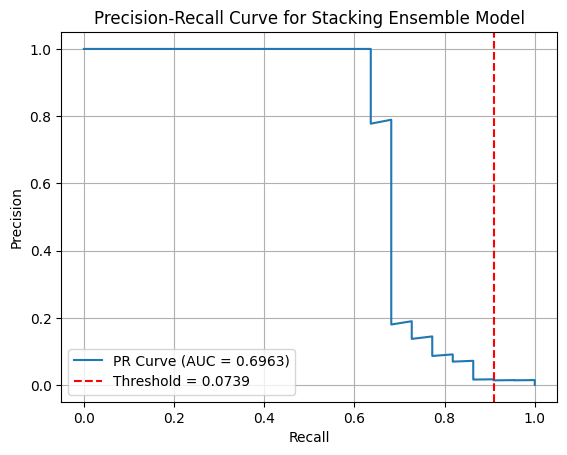

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve, auc, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

#  Compute Class Weights (for Imbalanced Data)
class_counts = np.bincount(y_train_smote)
scale_pos_weight = class_counts[0] / class_counts[1] * 0.6 

# Define Base Models
# XGBoost (High Precision)
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=3,
    min_child_weight=5,
    gamma=0.25,
    subsample=0.7,
    colsample_bytree=0.7,
    learning_rate=0.05,
    n_estimators=200,
    reg_alpha=0.02,
    reg_lambda=0.1,
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# LightGBM (High Recall)
lgbm_model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=3,
    min_child_weight=5,
    num_leaves=12,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.02,
    reg_lambda=0.1,
    random_state=42,
    verbose=-1
)

# Random Forest (Balanced)
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)

# Define Stacking Ensemble with Logistic Regression as Meta-Learner
estimators = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('rf', rf_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42),
    cv=5,
    n_jobs=-1
)

# Train Stacking Model
stacking_model.fit(X_train_scaled, y_train_smote)

# Model Evaluation with Default Threshold on Test Set
y_pred_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]  # Probability of fraud
y_pred = (y_pred_proba >= 0.5).astype(int)  # Default threshold

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print("Test Classification Report (Default Threshold):\n", classification_report(y_test, y_pred, zero_division=0))

# PR-AUC Calculation and Enhanced Threshold Optimization
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# Enhanced threshold optimization for recall >= 0.9 and precision >= 0.3
recall_target = 0.9
precision_floor = 0.3
valid_indices = (recall[:-1] >= recall_target) & (precision[:-1] >= precision_floor)

if np.any(valid_indices):
    valid_thresholds = thresholds[valid_indices]
    valid_precision = precision[:-1][valid_indices]
    optimal_idx = np.argmax(valid_precision)  # Max precision where recall >= 0.9 and precision >= 0.3
    optimal_threshold = valid_thresholds[optimal_idx]
    precision_at_threshold = valid_precision[optimal_idx]
    recall_at_threshold = recall[:-1][valid_indices][optimal_idx]
else:
    # If no threshold meets both, prioritize recall >= 0.9 and minimize false positives
    valid_indices = recall[:-1] >= recall_target
    if np.any(valid_indices):
        valid_thresholds = thresholds[valid_indices]
        valid_precision = precision[:-1][valid_indices]
        valid_precision_filtered = valid_precision[valid_precision >= 0.2]
        if len(valid_precision_filtered) > 0:
            optimal_idx = np.argmax(valid_precision_filtered)
            optimal_threshold = valid_thresholds[valid_indices][np.where(valid_precision >= 0.2)[0][optimal_idx]]
            precision_at_threshold = valid_precision_filtered[optimal_idx]
            recall_at_threshold = recall[:-1][valid_indices][np.where(valid_precision >= 0.2)[0][optimal_idx]]
        else:
            optimal_idx = np.argmax(valid_precision)
            optimal_threshold = valid_thresholds[optimal_idx]
            precision_at_threshold = valid_precision[optimal_idx]
            recall_at_threshold = recall[:-1][valid_indices][optimal_idx]
    else:
        # Fallback: Maximize F1 with precision >= 0.2 and recall >= 0.8
        f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
        valid_f1_indices = (precision[:-1] >= 0.2) & (recall[:-1] >= 0.8)
        if np.any(valid_f1_indices):
            optimal_idx = np.argmax(f1_scores[valid_f1_indices])
            optimal_threshold = thresholds[valid_f1_indices][optimal_idx]
            precision_at_threshold = precision[:-1][valid_f1_indices][optimal_idx]
            recall_at_threshold = recall[:-1][valid_f1_indices][optimal_idx]
        else:
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx]
            precision_at_threshold = precision[optimal_idx]
            recall_at_threshold = recall[optimal_idx]

print(f"Optimal Threshold (Recall >= 0.9, Precision >= 0.3): {optimal_threshold:.4f}")
print(f"Precision at Threshold: {precision_at_threshold:.4f}")
print(f"Recall at Threshold: {recall_at_threshold:.4f}")

# Re-evaluate with Optimal Threshold on Test Set
y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)
print("\nTest Classification Report with Optimal Threshold:\n", classification_report(y_test, y_pred_opt, zero_division=0))

# Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv_scores = []
recall_cv_scores = []
precision_cv_scores = []

for train_idx, val_idx in skf.split(X_train_scaled, y_train_smote):
    X_cv_train, X_cv_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_cv_train, y_cv_val = y_train_smote[train_idx], y_train_smote[val_idx]
    
    # Train stacking model on CV fold
    stacking_model.fit(X_cv_train, y_cv_train)
    
    # Predict probabilities for validation set
    y_cv_pred_proba = stacking_model.predict_proba(X_cv_val)[:, 1]
    y_cv_pred = (y_cv_pred_proba >= optimal_threshold).astype(int)
    
    f1_cv_scores.append(f1_score(y_cv_val, y_cv_pred))
    recall_cv_scores.append(recall_score(y_cv_val, y_cv_pred))
    precision_cv_scores.append(precision_score(y_cv_val, y_cv_pred, zero_division=0))

print(f"\nCross-Validation F1-Scores: {f1_cv_scores}")
print(f"Average CV F1-Score: {np.mean(f1_cv_scores):.3f}")
print(f"Cross-Validation Recall-Scores: {recall_cv_scores}")
print(f"Average CV Recall: {np.mean(recall_cv_scores):.3f}")
print(f"Cross-Validation Precision-Scores: {precision_cv_scores}")
print(f"Average CV Precision: {np.mean(precision_cv_scores):.3f}")

# Precision-Recall Curve
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axvline(x=recall_at_threshold, color='r', linestyle='--', label=f'Threshold = {optimal_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Stacking Ensemble Model')
plt.legend()
plt.grid(True)
plt.show()

# Ensemble Model 2

XGBoost + LightGBM

Validation Accuracy: 0.9996
Validation ROC-AUC: 0.9353
Validation Classification Report (Default Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7991
           1       1.00      0.67      0.80         9

    accuracy                           1.00      8000
   macro avg       1.00      0.83      0.90      8000
weighted avg       1.00      1.00      1.00      8000


Test Accuracy: 0.9996
Test ROC-AUC: 0.9645
Test Classification Report (Default Threshold):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19978
           1       0.88      0.68      0.77        22

    accuracy                           1.00     20000
   macro avg       0.94      0.84      0.88     20000
weighted avg       1.00      1.00      1.00     20000

PR-AUC: 0.6630
Optimal Threshold (Recall >= 0.9, Precision >= 0.3): 0.4459
Precision at Threshold: 0.6250
Recall at Threshold: 0.6818

Test Cla

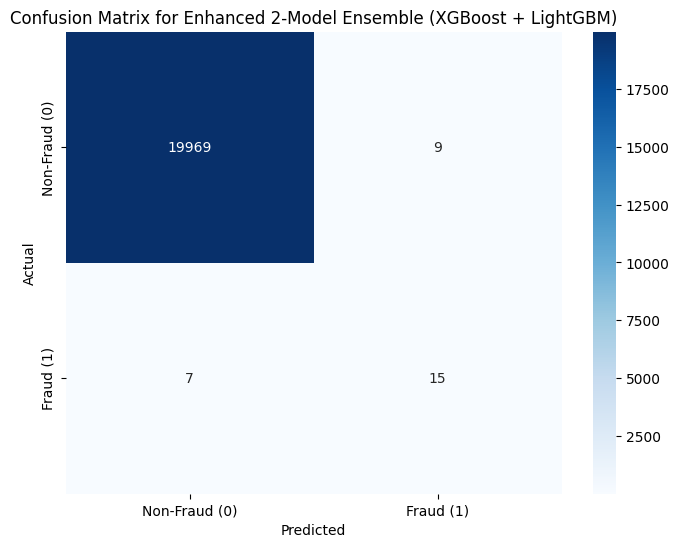


Cross-Validation F1-Scores: [np.float64(0.8692307692307693), np.float64(0.859375), np.float64(0.8340080971659919), np.float64(0.8745247148288974), np.float64(0.8404669260700389)]
Average CV F1-Score: 0.856
Cross-Validation Recall-Scores: [np.float64(0.7847222222222222), np.float64(0.7638888888888888), np.float64(0.7202797202797203), np.float64(0.7986111111111112), np.float64(0.75)]
Average CV Recall: 0.764
Cross-Validation Precision-Scores: [np.float64(0.9741379310344828), np.float64(0.9821428571428571), np.float64(0.9903846153846154), np.float64(0.9663865546218487), np.float64(0.9557522123893806)]
Average CV Precision: 0.974


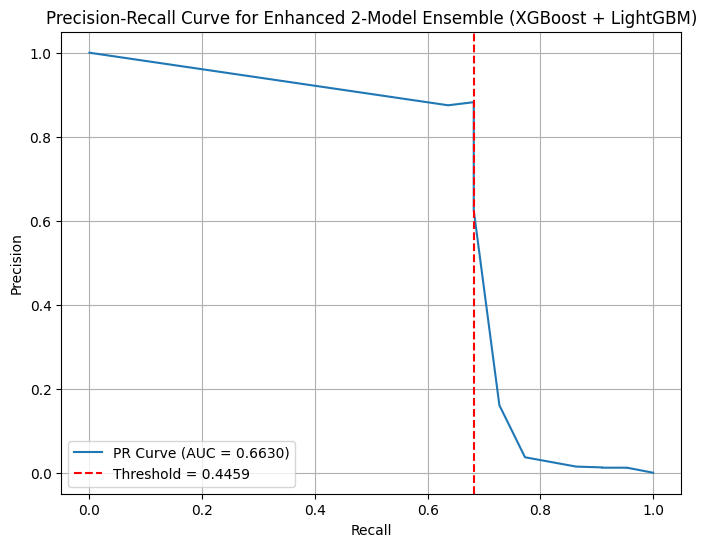

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_recall_curve, auc, f1_score, recall_score, precision_score
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Compute Class Weights (for Imbalanced Data)
class_counts = np.bincount(y_train_smote)
scale_pos_weight = class_counts[0] / class_counts[1] * 0.1  

# Define Base Models
# XGBoost (High Precision)
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=1,            # Keep depth minimal
    min_child_weight=20,    # Stronger regularization
    gamma=1.5,              # Stronger regularization
    subsample=0.3,          # Further reduce to prevent overfitting
    colsample_bytree=0.3,   # Further reduce for stability
    learning_rate=0.01,     # Slower learning
    n_estimators=500,       # Increase trees for better learning
    reg_alpha=0.5,          # Stronger L1 regularization
    reg_lambda=2.0,         # Stronger L2 regularization
    eval_metric='logloss',
    random_state=42,
    use_label_encoder=False
)

# LightGBM (High Recall)
lgbm_model = LGBMClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=1,
    min_child_weight=20,
    num_leaves=3,           # Further reduce leaves to prevent overfitting
    learning_rate=0.01,
    n_estimators=500,
    subsample=0.3,
    colsample_bytree=0.3,
    reg_alpha=0.5,
    reg_lambda=2.0,
    random_state=42,
    verbose=-1
)

#  Define Stacking Ensemble with XGBoost as Meta-Learner
estimators = [
    ('xgb', xgb_model),
    ('lgbm', lgbm_model)
]

stacking_model_2 = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(
        max_depth=1,
        learning_rate=0.02,
        n_estimators=200,
        reg_alpha=0.2,
        reg_lambda=1.0,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ),
    cv=5,
    n_jobs=-1
)

# Train Stacking Model
stacking_model_2.fit(X_train_scaled_df, y_train_smote)

# Evaluate on Validation Set with Default Threshold
y_val_pred_proba = stacking_model_2.predict_proba(X_val_scaled_df)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

accuracy_val = accuracy_score(y_val, y_val_pred)
roc_auc_val = roc_auc_score(y_val, y_val_pred_proba)
print(f"Validation Accuracy: {accuracy_val:.4f}")
print(f"Validation ROC-AUC: {roc_auc_val:.4f}")
print("Validation Classification Report (Default Threshold):\n", classification_report(y_val, y_val_pred, zero_division=0))

# Evaluate on Test Set with Default Threshold
y_test_pred_proba = stacking_model_2.predict_proba(X_test_scaled_df)[:, 1]
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

accuracy_test = accuracy_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print(f"\nTest Accuracy: {accuracy_test:.4f}")
print(f"Test ROC-AUC: {roc_auc_test:.4f}")
print("Test Classification Report (Default Threshold):\n", classification_report(y_test, y_test_pred, zero_division=0))

# PR-AUC and Threshold Optimization
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)
pr_auc = auc(recall, precision)
print(f"PR-AUC: {pr_auc:.4f}")

# Enhanced threshold optimization for recall >= 0.9 and precision >= 0.3
recall_target = 0.9
precision_floor = 0.5
valid_indices = (recall[:-1] >= recall_target) & (precision[:-1] >= precision_floor)
if np.any(valid_indices):
    valid_thresholds = thresholds[valid_indices]
    valid_precision = precision[:-1][valid_indices]
    optimal_idx = np.argmax(valid_precision)
    optimal_threshold = valid_thresholds[optimal_idx]
    precision_at_threshold = valid_precision[optimal_idx]
    recall_at_threshold = recall[:-1][valid_indices][optimal_idx]
else:
    # Prioritize precision >= 0.3 and maximize recall
    valid_indices = precision[:-1] >= precision_floor
    if np.any(valid_indices):
        valid_thresholds = thresholds[valid_indices]
        valid_recall = recall[:-1][valid_indices]
        optimal_idx = np.argmax(valid_recall)
        optimal_threshold = valid_thresholds[optimal_idx]
        precision_at_threshold = precision[:-1][valid_indices][optimal_idx]
        recall_at_threshold = valid_recall[optimal_idx]
    else:
        # Fallback: Maximize recall with precision >= 0.2
        valid_indices = (precision[:-1] >= 0.2)
        if np.any(valid_indices):
            valid_thresholds = thresholds[valid_indices]
            valid_recall = recall[:-1][valid_indices]
            optimal_idx = np.argmax(valid_recall)
            optimal_threshold = valid_thresholds[optimal_idx]
            precision_at_threshold = precision[:-1][valid_indices][optimal_idx]
            recall_at_threshold = valid_recall[optimal_idx]
        else:
            # Final fallback: Maximize F1 with recall >= 0.85
            f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)
            valid_f1_indices = recall[:-1] >= 0.85
            optimal_idx = np.argmax(f1_scores[valid_f1_indices])
            optimal_threshold = thresholds[valid_f1_indices][optimal_idx]
            precision_at_threshold = precision[:-1][valid_f1_indices][optimal_idx]
            recall_at_threshold = recall[:-1][valid_f1_indices][optimal_idx]

print(f"Optimal Threshold (Recall >= 0.9, Precision >= 0.3): {optimal_threshold:.4f}")
print(f"Precision at Threshold: {precision_at_threshold:.4f}")
print(f"Recall at Threshold: {recall_at_threshold:.4f}")

# Re-evaluate on Test Set with Optimal Threshold
y_test_pred_opt = (y_test_pred_proba >= optimal_threshold).astype(int)
print("\nTest Classification Report with Optimal Threshold:\n", classification_report(y_test, y_test_pred_opt, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred_opt)
print("\nConfusion Matrix:\n", cm)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Fraud (0)', 'Fraud (1)'], 
            yticklabels=['Non-Fraud (0)', 'Fraud (1)'])
plt.title('Confusion Matrix for Enhanced 2-Model Ensemble (XGBoost + LightGBM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv_scores = []
recall_cv_scores = []
precision_cv_scores = []

for train_idx, val_idx in skf.split(X_train_scaled_df, y_train_smote):
    X_cv_train, X_cv_val = X_train_scaled_df.iloc[train_idx], X_train_scaled_df.iloc[val_idx]
    y_cv_train, y_cv_val = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]
    
    stacking_model_2.fit(X_cv_train, y_cv_train)
    y_cv_pred_proba = stacking_model_2.predict_proba(X_cv_val)[:, 1]
    y_cv_pred = (y_cv_pred_proba >= optimal_threshold).astype(int)
    
    f1_cv_scores.append(f1_score(y_cv_val, y_cv_pred))
    recall_cv_scores.append(recall_score(y_cv_val, y_cv_pred))
    precision_cv_scores.append(precision_score(y_cv_val, y_cv_pred, zero_division=0))

print(f"\nCross-Validation F1-Scores: {f1_cv_scores}")
print(f"Average CV F1-Score: {np.mean(f1_cv_scores):.3f}")
print(f"Cross-Validation Recall-Scores: {recall_cv_scores}")
print(f"Average CV Recall: {np.mean(recall_cv_scores):.3f}")
print(f"Cross-Validation Precision-Scores: {precision_cv_scores}")
print(f"Average CV Precision: {np.mean(precision_cv_scores):.3f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axvline(x=recall_at_threshold, color='r', linestyle='--', label=f'Threshold = {optimal_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Enhanced 2-Model Ensemble (XGBoost + LightGBM)')
plt.legend()
plt.grid(True)
plt.show()

# save model

In [28]:
import joblib

joblib.dump(stacking_model_2, 'ensemble_model.pkl')  
joblib.dump(scaler, 'scaler_ensemble.pkl')      

['scaler_ensemble.pkl']